In [5]:
#!/usr/bin/env python
"""
BlueRov video capture class
"""

import cv2
import gi
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
gi.require_version('Gst', '1.0')
from gi.repository import Gst



In [2]:

class Video():
    """BlueRov video capture class constructor

    Attributes:
        port (int): Video UDP port
        video_codec (string): Source h264 parser
        video_decode (string): Transform YUV (12bits) to BGR (24bits)
        video_pipe (object): GStreamer top-level pipeline
        video_sink (object): Gstreamer sink element
        video_sink_conf (string): Sink configuration
        video_source (string): Udp source ip and port
        latest_frame (np.ndarray): Latest retrieved video frame
    """

    def __init__(self, port=5600):
        """Summary

        Args:
            port (int, optional): UDP port
        """

        Gst.init(None)

        self.port = port
        self.latest_frame = self._new_frame = None

        # [Software component diagram](https://www.ardusub.com/software/components.html)
        # UDP video stream (:5600)
        self.video_source = 'udpsrc port={}'.format(self.port)
        # [Rasp raw image](http://picamera.readthedocs.io/en/release-0.7/recipes2.html#raw-image-capture-yuv-format)
        # Cam -> CSI-2 -> H264 Raw (YUV 4-4-4 (12bits) I420)
        self.video_codec = '! application/x-rtp, payload=96 ! rtph264depay ! h264parse ! avdec_h264'
        # Python don't have nibble, convert YUV nibbles (4-4-4) to OpenCV standard BGR bytes (8-8-8)
        self.video_decode = \
            '! decodebin ! videoconvert ! video/x-raw,format=(string)BGR ! videoconvert'
        # Create a sink to get data
        self.video_sink_conf = \
            '! appsink emit-signals=true sync=false max-buffers=2 drop=true'

        self.video_pipe = None
        self.video_sink = None

        self.run()

    def start_gst(self, config=None):
        """ Start gstreamer pipeline and sink
        Pipeline description list e.g:
            [
                'videotestsrc ! decodebin', 
                '! videoconvert ! video/x-raw,format=(string)BGR ! videoconvert',
                '! appsink'
            ]

        Args:
            config (list, optional): Gstreamer pileline description list
        """

        if not config:
            config = \
                [
                    'videotestsrc ! decodebin',
                    '! videoconvert ! video/x-raw,format=(string)BGR ! videoconvert',
                    '! appsink'
                ]

        command = ' '.join(config)
        self.video_pipe = Gst.parse_launch(command)
        self.video_pipe.set_state(Gst.State.PLAYING)
        self.video_sink = self.video_pipe.get_by_name('appsink0')

    @staticmethod
    def gst_to_opencv(sample):
        """Transform byte array into np array

        Args:
            sample (TYPE): Description

        Returns:
            TYPE: Description
        """
        buf = sample.get_buffer()
        caps_structure = sample.get_caps().get_structure(0)
        array = np.ndarray(
            (
                caps_structure.get_value('height'),
                caps_structure.get_value('width'),
                3
            ),
            buffer=buf.extract_dup(0, buf.get_size()), dtype=np.uint8)
        return array

    def frame(self):
        """ Get Frame

        Returns:
            np.ndarray: latest retrieved image frame
        """
        if self.frame_available:
            self.latest_frame = self._new_frame
            # reset to indicate latest frame has been 'consumed'
            self._new_frame = None
        return self.latest_frame

    def frame_available(self):
        """Check if a new frame is available

        Returns:
            bool: true if a new frame is available
        """
        return self._new_frame is not None

    def run(self):
        """ Get frame to update _new_frame
        """

        self.start_gst(
            [
                self.video_source,
                self.video_codec,
                self.video_decode,
                self.video_sink_conf
            ])

        self.video_sink.connect('new-sample', self.callback)

    def callback(self, sink):
        sample = sink.emit('pull-sample')
        self._new_frame = self.gst_to_opencv(sample)

        return Gst.FlowReturn.OK


In [3]:


#reate the video object
# Add port= if is necessary to use a different one
video = Video()

print('Initialising stream...')
waited = 0
while not video.frame_available():
    waited += 1
    print('\r  Frame not available (x{})'.format(waited), end='')
    #cv2.waitKey(30)
print('\nSuccess!\nStarting streaming - press "q" to quit.')



Initialising stream...
  Frame not available (x11482)
Success!
Starting streaming - press "q" to quit.


In [7]:

# Wait for the next frame to become available
if video.frame_available():
    # Only retrieve and display a frame if it's new
    frame = video.frame()
    #cv2.imshow('frame', frame)
# Allow frame to display, and check if user wants to quit



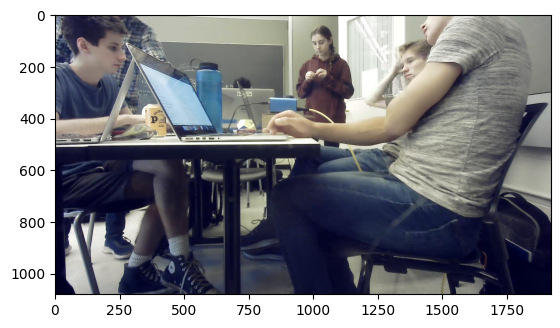

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
